In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import sys
sys.path.append("../src/")

In [3]:
#export
from nb_07 import *

## Imagenette data

In [4]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [5]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=128

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [6]:
nfs = [32,64,128,256]

In [7]:
cbfs = [partial(AvgStatsCallback,accuracy), CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [8]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [9]:
run.fit(1, learn)

train: [1.766554637171296, tensor(0.3893, device='cuda:0')]
valid: [1.5746651074840765, tensor(0.4810, device='cuda:0')]


## Refining the optimizer

In PyTorch, the base optimizer in torch.optim is just a dictionary that stores the hyper-parameters and references to the parameters of the model we want to train in parameter groups (different groups can have different learning rates/momentum/weight decay... which is what lets us do discriminative learning rates).

It contains a method step that will update our parameters with the gradients and a method zero_grad to detach and zero the gradients of all our parameters.

We build the equivalent from scratch, only ours will be more flexible. In our implementation, the step function loops over all the parameters to execute the step using stepper functions that we have to provide when initializing the optimizer.

In [10]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        # might be a generator
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]
        self.steppers = listify(steppers)

    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()

    def step(self):
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)

In [11]:
#export
def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data)
    return p

In [12]:
opt_func = partial(Optimizer, steppers=[sgd_step])

Now that we have changed the optimizer, we will need to adjust the callbacks that were using properties from the PyTorch optimizer: in particular the hyper-parameters are in the list of dictionaries opt.hypers (PyTorch has everything in the the list of param groups).

In [13]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        
    def plot(self, skip_last=0):
        losses = [o.item() for o in self.losses]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs):
        self.pname,self.sched_funcs = pname,listify(sched_funcs)

    def begin_batch(self): 
        if not self.in_train: return
        fs = self.sched_funcs
        if len(fs)==1: fs = fs*len(self.opt.param_groups)
        pos = self.n_epochs/self.epochs
        for f,h in zip(fs,self.opt.hypers): h[self.pname] = f(pos)
            
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.hypers: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [14]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

In [15]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback, Recorder,
        partial(ParamScheduler, 'lr', sched)]

In [16]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=opt_func)

In [17]:
%time run.fit(1, learn)

train: [1.7990999825087126, tensor(0.3819, device='cuda:0')]
valid: [1.539555384156051, tensor(0.4762, device='cuda:0')]
CPU times: user 3.87 s, sys: 1.57 s, total: 5.44 s
Wall time: 21.2 s


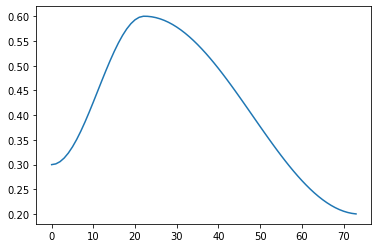

In [18]:
run.recorder.plot_lr()

## Weight decay

In [19]:
#export
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1 - lr*wd)
    return p
weight_decay._defaults = dict(wd=0.)

In [20]:
#export
def l2_reg(p, lr, wd, **kwargs):
    p.grad.data.add_(wd, p.data)
    return p
l2_reg._defaults = dict(wd=0.)

Let's allow steppers to add to our defaults (which are the default values of all the hyper-parameters). This helper function adds in dest the key/values it finds while going through os and applying f when they was no key of the same name.

In [21]:
#export
def maybe_update(os, dest, f):
    for o in os:
        for k,v in f(o).items():
            if k not in dest: dest[k] = v

def get_defaults(d): return getattr(d,'_defaults',{})

This is the same as before, we just take the default values of the steppers when none are provided in the kwargs.

In [22]:
#export
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults)
        # might be a generator
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]

    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()

    def step(self):
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)

In [23]:
#export
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults)
        # might be a generator
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]

    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()

    def step(self):
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)

In [24]:
#export 
sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])

In [25]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=sgd_opt)

In [26]:
model = learn.model

In [27]:
opt = sgd_opt(model.parameters(), lr=0.1)

In [28]:
opt.hypers[0]['wd'] # default value

0.0

In [29]:
opt.hypers[0]['lr'] # default value

0.1

In [30]:
opt = sgd_opt(model.parameters(), lr=0.1, wd=1e-4)

In [31]:
cbfs = [partial(AvgStatsCallback,accuracy), CudaCallback]

In [32]:
learn,run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs, opt_func=partial(sgd_opt, wd=0.01))

In [33]:
run.fit(1, learn)

train: [1.8053417731545043, tensor(0.3748, device='cuda:0')]
valid: [1.657086733678344, tensor(0.4171, device='cuda:0')]


## With momentum

Momentum requires to add some state. We need to save the moving average of the gradients to be able to do the step and store this inside the optimizer state. To do this, we introduce statistics. Statistics are object with two methods:

init_state, that returns the initial state (a tensor of 0. for the moving average of gradients)
update, that updates the state with the new gradient value
We also read the _defaults values of those objects, to allow them to provide default values to hyper-parameters.

In [34]:
#export
class StatefulOptimizer(Optimizer):
    def __init__(self, params, steppers, stats=None, **defaults): 
        self.stats = listify(stats)
        maybe_update(self.stats, defaults, get_defaults)
        super().__init__(params, steppers, **defaults)
        self.state = {}
        
    def step(self):
        for p,hyper in self.grad_params():
            if p not in self.state:
                #Create a state for p and call all the statistics to initialize it.
                self.state[p] = {}
                maybe_update(self.stats, self.state[p], lambda o: o.init_state(p))
            state = self.state[p]
            for stat in self.stats: state = stat.update(p, state, **hyper)
            compose(p, self.steppers, **state, **hyper)
            self.state[p] = state

In [35]:
#export
class Stat():
    _defaults = {}
    def init_state(self, p): raise NotImplementedError
    def update(self, p, state, **kwargs): raise NotImplementedError

In [36]:
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)

    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['grad_avg'].mul_(mom).add_(p.grad.data)
        return state

In [37]:
#export
def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(-lr, grad_avg)
    return p

In [38]:
sgd_mom_opt = partial(StatefulOptimizer, steppers=[momentum_step,weight_decay],
                  stats=AverageGrad(), wd=0.01)

In [39]:
learn,run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs, opt_func=sgd_mom_opt)

In [40]:
run.fit(1, learn)

train: [2.0765592410101386, tensor(0.3088, device='cuda:0')]
valid: [2.4024987559713376, tensor(0.2665, device='cuda:0')]


In [41]:
#export
def lin_comb(v1, v2, beta): return beta*v1 + (1-beta)*v2

## Adam and friends

In Adam, we use the gradient averages but with dampening (not like in SGD with momentum), so let's add this to the AverageGrad class.

In [42]:
#export
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    
    def __init__(self, dampening:bool=False): self.dampening=dampening
    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['mom_damp'] = 1-mom if self.dampening else 1.
        state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)
        return state

We also need to track the moving average of the gradients squared.

In [43]:
#export
class AverageSqrGrad(Stat):
    _defaults = dict(sqr_mom=0.99)
    
    def __init__(self, dampening:bool=True): self.dampening=dampening
    def init_state(self, p): return {'sqr_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, sqr_mom, **kwargs):
        state['sqr_damp'] = 1-sqr_mom if self.dampening else 1.
        state['sqr_avg'].mul_(sqr_mom).addcmul_(state['sqr_damp'], p.grad.data, p.grad.data)
        return state

We will also need the number of steps done during training for the debiasing.

In [44]:
#export
class StepCount(Stat):
    def init_state(self, p): return {'step': 0}
    def update(self, p, state, **kwargs):
        state['step'] += 1
        return state

This helper function computes the debias term. If we dampening, damp = 1 - mom and we get the same result as before. If we don't use dampening, (damp = 1) we will need to divide by 1 - mom because that term is missing everywhere.

In [45]:
#export
def debias(mom, damp, step): return damp * (1 - mom**step) / (1-mom)

In [46]:
#export
def adam_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    p.data.addcdiv_(-lr / debias1, grad_avg, (sqr_avg/debias2).sqrt() + eps)
    return p
adam_step._defaults = dict(eps=1e-5)

In [47]:
#export
def adam_opt(xtra_step=None, **kwargs):
    return partial(StatefulOptimizer, steppers=[adam_step,weight_decay]+listify(xtra_step),
                   stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()], **kwargs)

In [48]:
learn,run = get_learn_run(nfs, data, 0.001, conv_layer, cbs=cbfs, opt_func=adam_opt())

In [49]:
run.fit(3, learn)

train: [1.7091763047510298, tensor(0.4128, device='cuda:0')]
valid: [1.539838027468153, tensor(0.4917, device='cuda:0')]
train: [1.1909504039497307, tensor(0.6077, device='cuda:0')]
valid: [1.2981253732085987, tensor(0.5730, device='cuda:0')]
train: [0.8826561509927131, tensor(0.7209, device='cuda:0')]
valid: [1.296531648089172, tensor(0.5766, device='cuda:0')]


In [50]:
%%bash
python3 "../src/notebook2script.py" 08_optimizers.ipynb

Converted 08_optimizers.ipynb to ../src/nb_08.py
